In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
fileName = '/home/pranav/Documents/leosIN/2013_04_04_GNSS_SIGNAL_at_CTTC_SPAIN/2013_04_04_GNSS_SIGNAL_at_CTTC_SPAIN.dat'

## PreProcessing

#### Constants

In [3]:
## Satellite Frequency
FREQ1 = 1.57542e9        #L1_CA
FREQ2 = 1.22760e9;       #  L2     frequency (Hz)
FREQ5 = 1.17645e9;       #  L5/E5a frequency (Hz)
FREQ6 = 1.27875e9;       #  E6/LEX frequency (Hz)
FREQ7 = 1.20714e9;       #  E5b    frequency (Hz)
FREQ8 = 1.191795e9;      #  E5a+b  frequency (Hz)
FREQ9 = 2.492028e9;      #  S      frequency (Hz)
FREQ1_GLO = 1.60200e9;   #  GLONASS G1 base frequency (Hz)
DFRQ1_GLO = 0.56250e6;   #  GLONASS G1 bias frequency (Hz/n)
FREQ2_GLO = 1.24600e9;   #  GLONASS G2 base frequency (Hz)
DFRQ2_GLO = 0.43750e6;   #  GLONASS G2 bias frequency (Hz/n)
FREQ3_GLO = 1.202025e9;  #  GLONASS G3 frequency (Hz)
FREQ1_BDS = 1.561098e9;  #  BeiDou B1 frequency (Hz)
FREQ2_BDS = 1.20714e9;   #  BeiDou B2 frequency (Hz)
FREQ3_BDS = 1.26852e9;   #  BeiDou B3 frequency (Hz)

In [4]:
#Sat frequency 
acq_fs = FREQ1
### Raw signal Parameters
IF = 0
samplingFreq=4e6
codeFreqBasis = 1.023e6
codeLength = 1023
samplesPerCode = round(samplingFreq/(codeFreqBasis/codeLength))

### Acquisition Settings
skipAcquisition = 0
acqSatelliteList = list(range(0,37))
acqSearchBand = 14
acqThreshold = 2.5
acquisitionCohCodePeriods=2
acquisitionNonCodePeriods=2

fileType=2
dataOffset=600    

#### File I/O

In [5]:
if fileType==1:
    dataType = np.complex64
elif fileType==2:
    dataType=np.int8
data= np.fromfile(fileName,dataType,offset=dataOffset,
count=10*(acquisitionCohCodePeriods*acquisitionNonCodePeriods)*samplesPerCode*6
)
data.shape

(960000,)

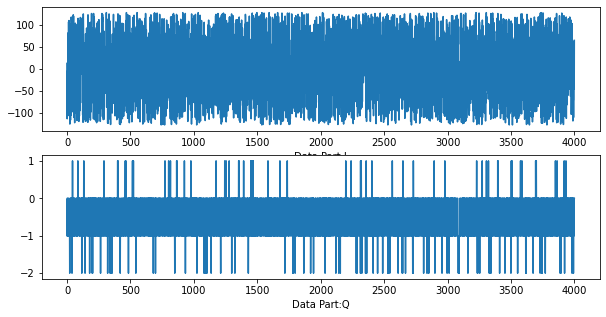

In [7]:
if fileType==2:
    oddData = data[::2]
    evenData = data[1::2]
    fig = plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.plot(oddData[:samplesPerCode])
    plt.xlabel('Data Part:I')
    plt.subplot(212)
    plt.plot(evenData[:samplesPerCode])
    plt.xlabel('Data Part:Q')


In [8]:
if fileType==2:
    signal = oddData + 1j*evenData
else:
    signal = data

#### Signal Processing

low_pass(	double 	gain,
double 	sampling_freq,
double 	cutoff_freq,
double 	transition_width,
win_type 	window = WIN_HAMMING,
double 	beta = 6.76 
)		

In [9]:
x=np.ones((6))
x[2:5]

array([1., 1., 1.])

## Acquisition

In [10]:
signal1 = signal[0:samplesPerCode]
signal2 = signal[samplesPerCode:2*samplesPerCode]
signal0DC = signal-np.mean(signal)
ts = 1/samplingFreq


In [11]:
def generateCACode(prn):
    g2s = [  5,   6,   7,   8,  17,  18, 139, 140, 141, 251,
       252, 254, 255, 256, 257, 258, 469, 470, 471, 472,
       473, 474, 509, 512, 513, 514, 515, 516, 859, 860,
       861, 862,863,950,947,948,950]
    
    g2shift = g2s[prn]
    
    g1 = np.zeros((1023))
    reg = -1*np.ones((10))
    for i in range(codeLength):
        g1[i]      = reg[9]
        saveBit    = reg[2]*reg[9]
        reg[1:10]   = reg[0:9]
        reg[0]     = saveBit
    
    g2 = np.zeros((1023))
    reg = -1*np.ones((10))
    for i in range(codeLength):
        g2[i] = reg[9]
        saveBit     = reg[1]*reg[2]*reg[5]*reg[7]*reg[8]*reg[9]
        reg[1:10]   = reg[0:9]
        reg[0]      = saveBit
        
    g2 = np.concatenate([g2[1023-g2shift:],g2[0:1023-g2shift]])
    CAcode = -1*np.multiply(g1,g2)
    return CAcode

def makeCATable():
    caCodesTable = np.zeros((37,samplesPerCode))
    ts = 1/samplingFreq
    tc = 1/codeFreqBasis
    
    for i in range(37):
        caCode = generateCACode(i)
        cvi = ts * np.arange(1,samplesPerCode+1)/ tc
        codeValueIndex = np.ceil(cvi-1)
    
        # Correct the last index (due to number rounding issues) -----------
        codeValueIndex[-1] = 1022
        codeValueIndex = list(map(int,list(codeValueIndex)))
        # Make the digitized version of the C/A code -----------------------
        #The "upsampled" code is made by selecting values form the CA code
        # chip array (caCode) for the time instances of each sample.
        caCodesTable[i, :] = caCode[codeValueIndex]
        
        
    return caCodesTable
   

#### Processing

In [12]:
phasePoints = (np.arange(0,samplesPerCode))*2*np.pi*ts
numberOfFrqBins = round(acqSearchBand*2)+1
caCodesTable = makeCATable()
results = np.zeros((numberOfFrqBins,samplesPerCode))
frqBins = np.zeros((numberOfFrqBins))

In [13]:
carrFreq = np.zeros((37))
codePhase = np.zeros((37))
peakMetric = np.zeros((37))


In [14]:
def acqResults():
    for i in acqSatelliteList:
        caCodesT = caCodesTable[i] 
        caCodeFreqDom = np.conj(np.fft.fft(caCodesT))
        for j in range(numberOfFrqBins):

            # Generate carrier wave frequency grid (0.5kHz step) -----------
            frqBins[j] = IF - (acqSearchBand/2) * 1000 + 0.25e3 * j

            # Generate local sine and cosine -------------------------------
            sigCarr = np.exp(1j*frqBins[j]*phasePoints)

            # "Remove carrier" from the signal -----------------------------
            I1      = np.real(sigCarr * signal1)
            Q1      = np.imag(sigCarr * signal1)
            I2      = np.real(sigCarr * signal2)
            Q2      = np.imag(sigCarr * signal2)

            # Convert the baseband signal to frequency domain --------------
            IQfreqDom1 = np.fft.fft(I1 + 1j*Q1)
            IQfreqDom2 = np.fft.fft(I2 + 1j*Q2)

            # Multiplication in the frequency domain (correlation in time%domain)
            convCodeIQ1 = np.multiply(IQfreqDom1, caCodeFreqDom)
            convCodeIQ2 = np.multiply(IQfreqDom2 , caCodeFreqDom)

            # Perform inverse DFT and store correlation results ------------
            acqRes1 =np.power(abs(np.fft.ifft(convCodeIQ1)),2)
            acqRes2 = np.power(abs(np.fft.ifft(convCodeIQ2)),2)

            # Check which msec had the greater power and save that, will
            # 1st and 2nd msec but will correct data bit issues
            if (max(acqRes1) > max(acqRes2)):
                results[j, :] = acqRes1
            else:
                results[j, :] = acqRes2
        np.savetxt('test.csv', results, delimiter=',', fmt='%s')
        # Looking for correlation peaks
        peakSize= np.amax(np.amax(results,axis=0))
        frequencyBinIndex = np.amax(results.argmax(axis=0),)#np.amax(np.where(results[j,:]==peakSize))
        frequencyBinIndex = frequencyBinIndex
        #print(peakSize,frequencyBinIndex)

        # Find code phase of the same correlation peak ---------------------
        peakSize = np.amax(np.amax(results,axis=1))
        codePhase = np.amax(results.argmax(axis=1))
        #print(peakSize,codePhase)
        # Find 1 chip wide C/A code phase exclude range around the peak ----
        samplesPerCodeChip   = round(samplingFreq /codeFreqBasis)
        excludeRangeIndex1 = codePhase - samplesPerCodeChip
        excludeRangeIndex2 = codePhase + samplesPerCodeChip

        # Correct C/A code phase exclude range if the range includes array
        #boundaries
        if excludeRangeIndex1 < 2:
            codePhaseRange = np.arange(excludeRangeIndex2 ,(samplesPerCode + excludeRangeIndex1-1))

        elif excludeRangeIndex2 >= samplesPerCode:
            codePhaseRange = np.arange(excludeRangeIndex2 - samplesPerCode,excludeRangeIndex1-1)
        else:
            codePhaseRange = np.hstack((np.arange(1,excludeRangeIndex1),np.arange(excludeRangeIndex2 ,samplesPerCode-1)))


        # Find the second highest correlation peak in the same freq. bin ---
        secondPeakSize = np.amax(results[frequencyBinIndex, codePhaseRange])
        #print(peakSize/secondPeakSize)
        # Store result -----------------------------------------------------
        peakMetric[i] = peakSize/secondPeakSize
        # If the result is above threshold, then there is a signal 
        if (peakSize/secondPeakSize) > acqThreshold:
            caCode = generateCACode(i)
            codeValueIndex = np.floor((ts * np.arange(1,10*samplesPerCode)) / 
                                   (1/codeFreqBasis))
            print(codeValueIndex)
            print(np.remainder(codeValueIndex,1023) + 1)
            longCaCode = caCode[int(np.remainder(codeValueIndex,1023) + 1)]

            # Remove C/A code modulation from the original signal ----------
            # (Using detected C/A code phase)
            xCarrier = np.multiply(signal0DC[codePhase:(codePhase + 10*samplesPerCode-1)] 
                , longCaCode)

            # Compute the magnitude of the FFT, find maximum and the
            #associated carrier frequency

            # Find the next highest power of two and increase by 8x --------
            fftNumPts = 8*(2**(nextpow2(length(xCarrier))))

            # Compute the magnitude of the FFT, find maximum and the
            #associated carrier frequency 
            fftxc = abs(np.fft.fft(xCarrier, fftNumPts))


            uniqFftPts = ceil((fftNumPts + 1) / 2)
            [fftMax, fftMaxIndex] = np.amax(fftxc),np.argmax(fftxc);
            fftFreqBins = np.arange(0 ,uniqFftPts-1) *samplingFreq/fftNumPts;
            if (fftMaxIndex > uniqFftPts): #%and should validate using complex data
                if (rem(fftNumPts,2)==0):  #even number of points, so DC and Fs/2 computed
                    fftFreqBinsRev=-fftFreqBins[(uniqFftPts-1):-1:2];
                    fftMax, fftMaxIndex = np.arange(np.amax(fftxc[(uniqFftPts+1),len(fftxc)])),np.argmax(fftxc[(uniqFftPts+1),len(fftxc)]);
                    carrFreq[i]  = -fftFreqBinsRev[fftMaxIndex];
                else:  #%odd points so only DC is not included
                    fftFreqBinsRev=-np.flip(fftFreqBins[2:(uniqFftPts)]);
                    [fftMax, fftMaxIndex] = np.amax(fftxc[(uniqFftPts+1):length(fftxc)]),np.argmax(fftxc[(uniqFftPts+1):length(fftxc)])
                    carrFreq[i] = fftFreqBinsRev[fftMaxIndex]
                end
            else:
                carrFreq[i]  = (-1)**(fileType-1)*fftFreqBins(fftMaxIndex);


            codePhase[i] = codePhase;
            print(i,end =" ")
        else:
            # No signal with this PRN --------------------------------------
            print('. ',end =" ")
    return peakMetric,results

In [15]:
peakMetric,results= acqResults()

.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  

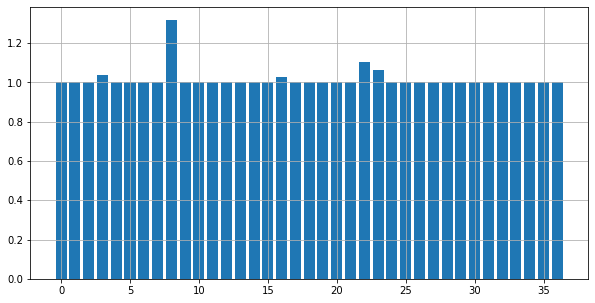

In [17]:
fig = plt.figure(figsize=(10,5))
plt.bar(list(range(37)),peakMetric)
plt.grid()